### Practicum I

# Rating Prediction with Online Learning Model

### Sri Sowmya Madabhushi

In [2]:
# import necessary libraries
import pandas as pd
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

import pickle
import os
import re

In [3]:
# read the csv file
reviews_df = pd.read_csv('amazon_reviews.csv')
reviews_df.head()

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (1,10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42


In [4]:
# check the rating and reviews columns
reviews_df = reviews_df[['reviews.rating','reviews.text']]
reviews_df.columns=['Rating','Review']
reviews_df.head()

,Rating,Review
0,5.0,This product so far has not disappointed. My c...
1,5.0,great for beginner or experienced person. Boug...
2,5.0,Inexpensive tablet for him to use and learn on...
3,4.0,I've had my Fire HD 8 two weeks now and I love...
4,5.0,I bought this for my grand daughter when she c...


In [5]:
# Preprocessing steps- checking if any nulls
reviews_df.isnull().sum()

Rating    33
Review     1
dtype: int64

In [6]:
# Dropping the null rows as very less number of nulls
reviews_df.dropna(inplace=True)
reviews_df.isnull().sum()

Rating    0
Review    0
dtype: int64

In [7]:
# Mapping each rating to number
ratingmap = {5:5,4:4,3:3,2:2,1:1}
reviews_df['Sentiment'] = reviews_df['Rating'].map(ratingmap)
reviews_df.drop(['Rating'], axis=1, inplace=True) 
reviews_df.dropna(subset=['Sentiment'], inplace=True) 
reviews_df['Sentiment']=reviews_df['Sentiment'].astype(int)

In [8]:
# check the reviews data
reviews_df.head()

,Review,Sentiment
0,This product so far has not disappointed. My c...,5
1,great for beginner or experienced person. Boug...,5
2,Inexpensive tablet for him to use and learn on...,5
3,I've had my Fire HD 8 two weeks now and I love...,4
4,I bought this for my grand daughter when she c...,5


In [9]:
# Check how many rows/data for each review type
reviews_df['Sentiment'].value_counts()

5    23774
4     8541
3     1499
1      410
2      402
Name: Sentiment, dtype: int64

<BarContainer object of 5 artists>

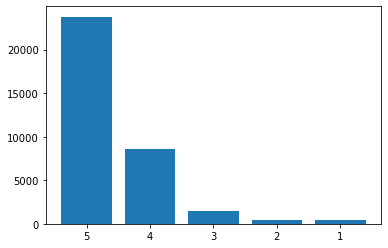

In [10]:
import matplotlib.pyplot as plt
plt.bar(np.array(['5', '4', '3', '2', '1']), np.array([23774,8541,1499,410,402]))

In [9]:
#Shape to see number of columns and rows
reviews_df.shape

(34626, 2)

In [10]:
from sklearn.utils import resample

# Separate majority and minority classes
df_5 = reviews_df[reviews_df.Sentiment==5]
df_4 = reviews_df[reviews_df.Sentiment==4]
df_3 = reviews_df[reviews_df.Sentiment==3]
df_2 = reviews_df[reviews_df.Sentiment==2]
df_1 = reviews_df[reviews_df.Sentiment==1]

 
# Downsample majority class
df_majority_downsampled_5 = resample(df_5, 
                                 replace=False,
                                 n_samples=1500,
                                 random_state=123)
df_majority_downsampled_4 = resample(df_4, 
                                 replace=False,
                                 n_samples=1500,
                                 random_state=123)
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled_5, df_majority_downsampled_4, df_3,df_2,df_1])
 
# Display new class counts
print(df_downsampled.Sentiment.value_counts())

# Check how many rows per rating
reviews_df=df_downsampled
reviews_df.reset_index(inplace=True)
reviews_df.drop(['index'], axis=1, inplace=True)
reviews_df.shape

5    1500
4    1500
3    1499
1     410
2     402
Name: Sentiment, dtype: int64


(5311, 2)

In [11]:
# Check the df
reviews_df.head()

,Review,Sentiment
0,I bought this since it has a special discount ...,5
1,I had a fire stick that I was having issues wi...,5
2,"I Love Love my Fire, you get way more than you...",5
3,"Ok, so I will not say its perfect but it is re...",5
4,Does every thing I would need it to. Nice inex...,5


In [12]:
# Check for nulls
reviews_df.isnull().sum()

Review       0
Sentiment    0
dtype: int64

In [13]:
# Shuffling the samples
reviews_df = reviews_df.sample(frac=1, random_state=0).reset_index(drop=True)

In [14]:
# Check the df
reviews_df.head()

,Review,Sentiment
0,"I love to read! Books,books, books and more bo...",5
1,I did my research and purchased one of these f...,5
2,Quality of kindle is pretty okay. Just wish ch...,4
3,I purchased the tablet as a screen for my drin...,3
4,The Tap is essentially a smaller version of th...,4


In [15]:
reviews_df.head(20)

,Review,Sentiment
0,"I love to read! Books,books, books and more bo...",5
1,I did my research and purchased one of these f...,5
2,Quality of kindle is pretty okay. Just wish ch...,4
3,I purchased the tablet as a screen for my drin...,3
4,The Tap is essentially a smaller version of th...,4
5,Works really well only wish it had larger memo...,4
6,Prob good for price but to many bugs. Freezes ...,2
7,This is a great tablet. This was the best one ...,4
8,"Whether you're a beginner or an expert, this t...",4
9,I love my Echo! it is easy to use and I also u...,5


In [16]:
#  methods for creating tokens

from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

def tokenizer(text):
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    return text.split()

def tokenizerporter(text):
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    return [porter.stem(word) for word in text.split()]


In [17]:
# Creating Tfidf vectorizer

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

tfidf.get_params().keys()

dict_keys(['analyzer', 'binary', 'decode_error', 'dtype', 'encoding', 'input', 'lowercase', 'max_df', 'max_features', 'min_df', 'ngram_range', 'norm', 'preprocessor', 'smooth_idf', 'stop_words', 'strip_accents', 'sublinear_tf', 'token_pattern', 'tokenizer', 'use_idf', 'vocabulary'])

In [18]:
# Splitting into test and train models
X_train = reviews_df.loc[:812, 'Review'].values
y_train = reviews_df.loc[:812, 'Sentiment'].values
X_test = reviews_df.loc[812:, 'Review'].values
y_test = reviews_df.loc[812:, 'Sentiment'].values

In [19]:
# DOwnloading stopwords from nltk package
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV


stop = stopwords.words('english')

# Creating list of parametrest for running the grid search against
param_grid = [{'vect__ngram_range': [(1, 1), (1, 2)],  # unigrams or bigrams
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizerporter],
               'clf__penalty': ['l1', 'l2'],
               'clf__n_iter_no_change': [1,2,3,5,7,9],
               'clf__alpha': [1e-2, 2e-2,3e-2,4e-2,5e-2,6e-2,7e-2,8e-2,9e-2,1e-1]},
              {'vect__ngram_range': [(1, 1), (1, 2)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizerporter],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__penalty': ['l1', 'l2'],
               'clf__n_iter_no_change': [1,2,3,5,7,9],
               'clf__alpha': [1e-2, 2e-2,3e-2,4e-2,5e-2,6e-2,7e-2,8e-2,9e-2,1e-1]},
              ]

# creating pipleline for running the vectorizer and SGD classifier
lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', SGDClassifier(loss='modified_huber', random_state=1))])
# Running grid search
gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=2,
                           n_jobs=-1)

In [21]:
# Fitting/Training the data 
gs_lr_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 1920 candidates, totalling 9600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 9105 tasks      | 

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=False,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [22]:
# Print the best params and accuracy for train data
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)

Best parameter set: {'clf__alpha': 0.09, 'clf__n_iter_no_change': 1, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizerporter at 0x7f8d1f0f8950>} 
CV Accuracy: 0.448


In [23]:
# Print the best params and accuracy for test data
clf = gs_lr_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

Test Accuracy: 0.423


In [24]:
# Creating hashing vectorizer for streaming data
vect = HashingVectorizer(decode_error='ignore',
                         n_features=2**21,
                         preprocessor=None,
                         ngram_range=(1,1),
                         stop_words=None,
                         tokenizer=tokenizer)

In [25]:
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

# Creating methods for streaming data
def stream_docs(df):
    for index, row in df.iterrows():
        text, label = row['Review'], row['Sentiment']
        yield text, label
        
def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            text, label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None, None
    return docs, y

# Saving the classifier
clf = SGDClassifier(loss='modified_huber', random_state=1, penalty='l2', alpha=0.09)

doc_stream = stream_docs(reviews_df)

In [26]:
# Training the classifier using the streaming data
classes = np.array([1, 2, 3,4,5])
for _ in range(45):
    X_train, y_train = get_minibatch(doc_stream, size=20)
    if not X_train:
        break
    X_train = vect.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)


In [27]:
# Model evaluation 

X_test, y_test = get_minibatch(doc_stream, size=20)
X_test = vect.transform(X_test)
print('Accuracy: %.3f' % clf.score(X_test, y_test))

Accuracy: 0.600


In [28]:
# Training the test data
clf = clf.partial_fit(X_test, y_test)

In [40]:
import pickle
import os

# Saving the classifier as a pickle
dest = os.path.join('website', 'pkl_objects')
if not os.path.exists(dest):
    os.makedirs(dest)

pickle.dump(clf, open(os.path.join(dest, 'amazon_classifier_2.pkl'), 'wb'), protocol=4)


In [41]:
# Saving tokenizer and vectorizer in a python file to be used in the web app
%%writefile website/amazonreview_vectorizer.py 
from sklearn.feature_extraction.text import HashingVectorizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import pickle
import re
import os

porter=PorterStemmer()

cur_dir = os.path.dirname(__file__)


def tokenizer(text):
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    return text.split()

def tokenizerporter(text):
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    return [porter.stem(word) for word in text.split()]

vect = HashingVectorizer(decode_error='ignore',
                         n_features=2**21,
                         preprocessor=None,
                         ngram_range=(1,1),
                         stop_words=None,
                         tokenizer=tokenizer)

Writing website/amazonreview_vectorizer.py


In [42]:
from sklearn.feature_extraction.text import HashingVectorizer

In [43]:
import os
os.chdir('website')

In [44]:
import pickle
import re
from amazonreview_vectorizer import vect

# Loading the saved pickle to test
model = pickle.load(open(os.path.join('pkl_objects', 'amazon_classifier_2.pkl'), 'rb'))

In [45]:
model

SGDClassifier(alpha=0.09, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=1, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [68]:
import numpy as np
# Testing
label = {1:1, 2:2, 3:3,4:4,5:5}

example = ["So happy love love love"]
X = vect.transform(example)
print('Prediction: %s\nProbability: %.2f%%' %\
      (label[model.predict(X)[0]], 
       np.max(model.predict_proba(X))*100))

Prediction: 5
Probability: 29.46%


In [47]:
label = {1:1, 2:2, 3:3,4:4,5:5}
# Testing
example = ["Won't buy again"]
X = vect.transform(example)
print('Prediction: %s\nProbability: %.2f%%' %\
      (label[model.predict(X)[0]], 
       np.max(model.predict_proba(X))*100))

Prediction: 3
Probability: 21.55%


In [70]:
label = {1:1, 2:2, 3:3,4:4,5:5}
# Testing

example = ["Bad product. never works"]
X = vect.transform(example)
print('Prediction: %s\nProbability: %.2f%%' %\
      (label[model.predict(X)[0]], 
       np.max(model.predict_proba(X))*100))

Prediction: 4
Probability: 22.63%


In [65]:
label = {1:1, 2:2, 3:3,4:4,5:5}
# Testing
example = ["not working sometimes"]
X = vect.transform(example)
print('Prediction: %s\nProbability: %.2f%%' %\
      (label[model.predict(X)[0]], 
       np.max(model.predict_proba(X))*100))

Prediction: 3
Probability: 23.38%


In [59]:
import os
os.chdir('../../../website')

In [62]:
# Creating SQLite database with the below columns
import sqlite3
import os

conn = sqlite3.connect('reviews_2.sqlite')
c = conn.cursor()

c.execute('DROP TABLE IF EXISTS review_db')
c.execute('CREATE TABLE review_db (review TEXT, actual_rating INTEGER, actual_sentiment TEXT, predicted_rating INTEGER, date TEXT)')


conn.commit()
conn.close()